In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
game_df = pd.read_csv("data/clean_game_data.csv")
skill_data = pd.read_csv("data/dependent_skill_data.csv")

random.seed(2049)

c:\Users\Colton\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


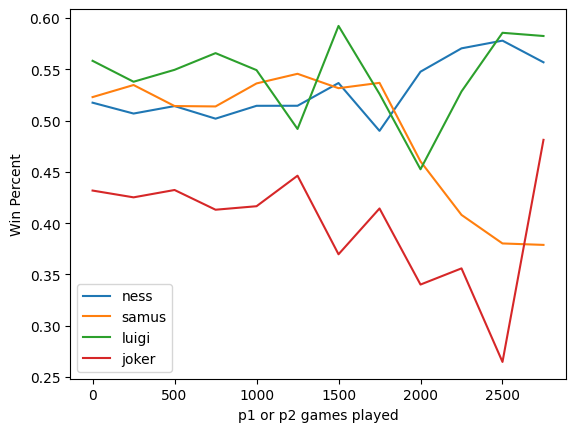

In [26]:
def win_percent(df):
    return (df[df["p1_won"] == True]["p1_char"].value_counts() + df[df["p1_won"] == False]["p2_char"].value_counts()) / \
              (df["p2_char"].value_counts() + df["p1_char"].value_counts())

def level_win_percent(df,level,step):
    return win_percent(df[
        (
        (df["p1_games_played"] >= level) & 
        (df["p1_games_played"] < level + step) 
        ) | (
        (df["p2_games_played"] >= level) & 
        (df["p2_games_played"] < level + step)
        )
        ]).sort_values(ascending=False)


def chargraph(characters, start = 0, stop = 1000, step = 50, df = game_df):
    if type(characters) == str:
        characters = [characters]
    graph = {char : list() for char in characters}
    for k in range(start,stop,step):
        LWP = level_win_percent(df,k,step)
        for char in characters:
            if char in LWP.index:
                graph[char].append(LWP[char])
            else:
                graph[char].append(np.NaN)
    for key in graph.keys():
        output, = plt.plot(range(start,stop,step), graph[key], label = key)
    plt.legend()
    plt.xlabel("p1 or p2 games played")
    plt.ylabel("Win Percent")
    return output

chargraph(["ness","samus","luigi","joker"],stop = 3000, step = 250)
plt.show()


We see that the variance of these lines increases with games played, likely because there are less players with many games played. We can decipher some trends in these lines visually, like how the mean of Ness and Luigi's win rate stays relatively constant, though the mean of Joker and Samus's seem to decrease. Let's verify that there are less players with many games played.

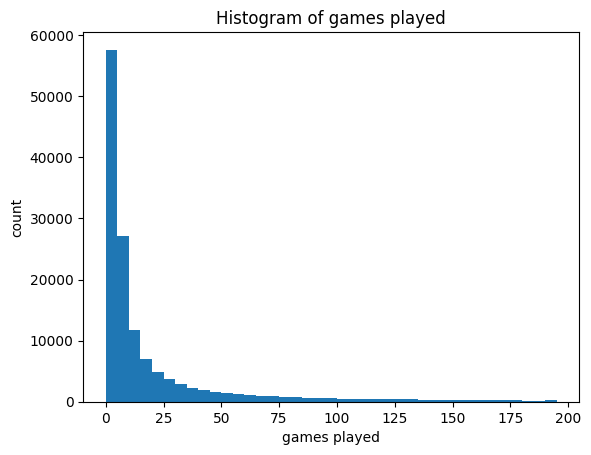

In [10]:
df1 = skill_data[["p1_id","p1_games_played"]].rename(columns = {"p1_id" : "player_id","p1_games_played" : "player_games_played"})
df2 = skill_data[["p2_id","p2_games_played"]].rename(columns = {"p2_id" : "player_id","p2_games_played" : "player_games_played"})
player_games_played_df = df1.append(df2,ignore_index = True).astype({"player_id" : "string", "player_games_played" : "int32"}).drop_duplicates(ignore_index=True).sort_values("player_games_played").reset_index(drop=True)
plt.hist(player_games_played_df["player_games_played"].to_list(),bins=range(0,200,5))
plt.title("Histogram of games played")
plt.ylabel("count")
plt.xlabel("games played")
plt.show()
#plt.hist(player_games_played_df[player_games_played_df["player_games_played"] >= 200]["player_games_played"].to_list(),bins=range(200,2000,50))
#plt.show() - has same 1/x graph

We can see that there are far less players with many games played than with few games played.

Question: How likely are you to beat someone who has played at least k times as many games as you?

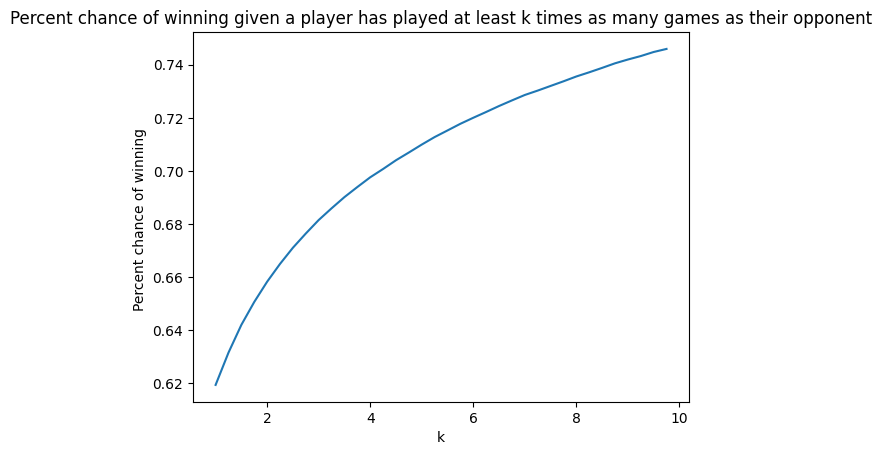

0.6192630428086423


In [11]:
def k_times_more_games_win_rate(k, df = game_df):
    return( (
                len(df[(df["p1_won"] == True) & (df["p1_games_played"] > k*df["p2_games_played"])]) + 
                len(df[(df["p1_won"] == False) & (df["p2_games_played"] > k*df["p1_games_played"])])
            ) /
            (
                len(df[(df["p1_games_played"] > k*df["p2_games_played"])]) + 
                len(df[(df["p2_games_played"] > k*df["p1_games_played"])])
            )
    )

graph = [k_times_more_games_win_rate(n/4) for n in range(4,40)]
plt.plot([(n/4) for n in range(4,40)],graph)
plt.xlabel("k")
plt.ylabel("Percent chance of winning ") 
plt.title("Percent chance of winning given a player has played at least k times as many games as their opponent") 
plt.show()
            
print(k_times_more_games_win_rate(1))


This graph may give us insights on what functions to apply to `p1_games_played` and `p2_games_played` in order to predict outcome. We know it must cap out at $1.0$ and bottom out at $0.0$, so it is possible it is graphing an S curve. This suggests a logistic regression may perform adequately for these predictors.

Also, this graph justifies the belief that games played is a metric of skill level. This means our first graph comparing character win percentage to games played is in some way equivalent to comparing character win percentage to skill level.

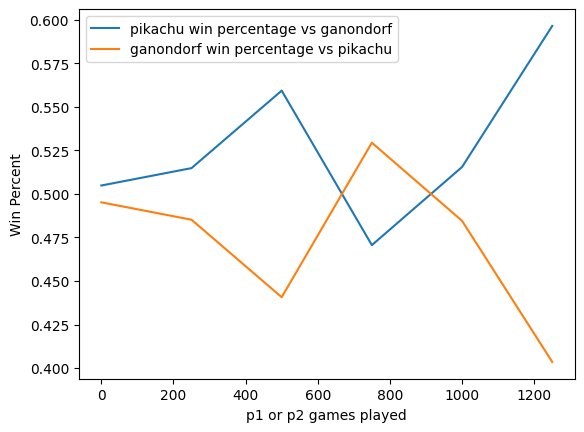

In [23]:
def vs_df(char1, char2):
    return game_df[((game_df["p1_char"] == char1) & (game_df["p2_char"] == char2)) |
                    ((game_df["p2_char"] == char1) & (game_df["p1_char"] == char2))]
def vsgraph(char1, char2, start = 0, stop = 1500, step = 250):
    chargraph(char1,df=vs_df(char1,char2),start=start, stop=stop, step=step).set_label(char1 + " win percentage vs " + char2)
    plt.legend()

vsgraph("pikachu","ganondorf")
vsgraph("ganondorf","pikachu")
    

We expect pikachu's win percentage vs ganondorf to be 1 minus ganondorf's win percentage against pikachu, and that is exactly what we see. This graph displayes how win percentage might vary based on both skill level and p1/p2 character.